In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import to_categorical

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12897385383966420613
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9215183422
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12818675078665686471
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Train Model

In [3]:
def unpickle(file, train=True):
    import pickle
    with open('./cifar10-python/cifar-10-batches-py/'+(('data_batch_'+str(file)) if train else 'test_batch'), 'rb') as fo:
        dict_d = pickle.load(fo, encoding='latin1')
    return np.reshape(dict_d['data'],(10000,3,32,32)).transpose(0, 2, 3, 1), dict_d['labels']
def normalization(x):
    return x/255

In [4]:
training_set = []
training_label = []
for i in range(1,6):
    x,y = unpickle(i)
    training_set.extend(x) 
    training_label.extend(y)

In [5]:
test_data,test_label = unpickle(0,train=False)
test_data_norm = normalization(np.array(test_data))
test_label_one_hot_encoded = to_categorical(test_label)

In [6]:
training_set_norm = np.array(training_set) / 255
training_label_one_hot_encode = to_categorical(training_label)

In [7]:
training_set.extend(test_data)
training_label_one_hot_encode = np.concatenate((training_label_one_hot_encode,test_label_one_hot_encoded))

In [8]:
training_set_norm = np.array(training_set) / 255

In [9]:
training_label_one_hot_encode.shape

(60000, 10)

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
datagen.fit(training_set_norm)

In [11]:
batch_size = 128
epochs = 10
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [12]:
labels_name = [
"airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"
]

In [13]:
counts = [0]*10
for i in training_label:
    counts[i] += 1
counts

[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

In [14]:
def plotImages(images_arr,lab):
    from matplotlib import pyplot as plt
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    for i in lab[:5]:
        print(labels_name[i], end=' ')

In [15]:
for i in range(0,20,5):
    plotImages(training_set_norm[i:i+5],training_label[i:i+5])

<Figure size 1000x1000 with 5 Axes>

frog truck truck deer automobile 

<Figure size 1000x1000 with 5 Axes>

automobile bird horse ship cat 

<Figure size 1000x1000 with 5 Axes>

deer horse horse bird truck 

<Figure size 1000x1000 with 5 Axes>

truck truck cat bird frog 

# test Data reading.

In [16]:
epochs = 100

In [22]:
# model = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#     MaxPooling2D((2,2),padding='same'),
#     Dropout(0.2),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(10, activation='softmax')
# ])

# train test merge:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=training_set_norm.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

opt = RMSprop(lr=0.0001, decay=1e-6)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
datagen.fit(training_set_norm)

model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 5:
        lrate = 0.0007
    if epoch > 10:
        lrate = 0.00005
    if epoch > 25:
        lrate = 0.0000001
    if epoch > 50:
        lrate = 0.00000005
    if epoch > 100:
        lrate = 0.00000001
    if epoch > 150:
        lrate = 0.000000005
    return lrate
history = model.fit_generator(
    datagen.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),
    steps_per_epoch=len(training_set_norm) / 16, 
    epochs=170,
    workers=8,
    callbacks=[LearningRateScheduler(lr_schedule)]
)
accuracy = model.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy[1])

Epoch 1/170
938/937 [==============================] - 8s 9ms/step - loss: 2.0276 - acc: 0.2220A: 0s - loss: 2.0402 - ac
Epoch 2/170
938/937 [==============================] - 8s 9ms/step - loss: 1.6642 - acc: 0.3953
Epoch 3/170
938/937 [==============================] - 8s 9ms/step - loss: 1.4896 - acc: 0.4700
Epoch 4/170
938/937 [==============================] - 8s 9ms/step - loss: 1.3752 - acc: 0.5288
Epoch 5/170
938/937 [==============================] - 8s 8ms/step - loss: 1.3227 - acc: 0.5485
Epoch 6/170
938/937 [==============================] - 8s 9ms/step - loss: 1.3037 - acc: 0.5576
Epoch 7/170
938/937 [==============================] - 8s 9ms/step - loss: 1.2132 - acc: 0.5937
Epoch 8/170
938/937 [==============================] - 8s 9ms/step - loss: 1.2462 - acc: 0.5900
Epoch 9/170
938/937 [==============================] - 8s 8ms/step - loss: 1.2555 - acc: 0.5874
Epoch 10/170
938/937 [==============================] - 8s 9ms/step - loss: 1.2914 - acc: 0.5780
Epoch 11/170
9

KeyboardInterrupt: 

In [23]:
# model1 = load_model('./model.h5')
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 5:
        lrate = 0.0007
    if epoch > 10:
        lrate = 0.00005
    if epoch > 25:
        lrate = 0.0000001
    if epoch > 50:
        lrate = 0.000000005
    if epoch > 100:
        lrate = 0.000000001
    if epoch > 150:
        lrate = 0.0000000005
    return lrate
history = model.fit_generator(
    datagen.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),
    steps_per_epoch=len(training_set_norm) / 16, 
    epochs=170,
    workers=4,
    callbacks=[LearningRateScheduler(lr_schedule)],
    initial_epoch=68
)
accuracy = model.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy[1])

Epoch 69/170
3750/3750 [==============================] - 28s 8ms/step - loss: 1.0606 - acc: 0.6590
Epoch 70/170
3750/3750 [==============================] - 28s 8ms/step - loss: 1.0595 - acc: 0.6594: 0s - loss: 1.0597 - 
Epoch 71/170
3750/3750 [==============================] - 28s 8ms/step - loss: 1.0579 - acc: 0.6585
Epoch 72/170
3750/3750 [==============================] - 29s 8ms/step - loss: 1.0561 - acc: 0.6581
Epoch 73/170
3750/3750 [==============================] - 28s 8ms/step - loss: 1.0606 - acc: 0.6602
Epoch 74/170
3750/3750 [==============================] - 28s 8ms/step - loss: 1.0577 - acc: 0.6592
Epoch 75/170
3750/3750 [==============================] - 28s 8ms/step - loss: 1.0622 - acc: 0.6573
Epoch 76/170
2739/3750 [====================>.........] - ETA: 7s - loss: 1.0603 - acc: 0.6586

KeyboardInterrupt: 

In [ ]:
model.save('./model.h5')

In [25]:
weight_decay = 1e-4
num_classes=10
model2 = Sequential()
model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=training_set_norm.shape[1:]))
model2.add(Activation('elu'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('elu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.2))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('elu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('elu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))
 
model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('elu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('elu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))
# model2.add(Dropout(0.4))
 
model2.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model2.add(Dense(num_classes, activation='softmax'))
datagen2 = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen2.fit(training_set_norm)
opt_rms2 = RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms2, metrics=['accuracy'])
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
history2 = model2.fit_generator(datagen.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),\
                    steps_per_epoch=training_set_norm.shape[0] // 32,epochs=125,\
                    verbose=1,validation_data=(test_data_norm,test_label_one_hot_encoded),callbacks=[LearningRateScheduler(lr_schedule)])
accuracy2 = model2.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy2[1])
model2.save('./model2.h5')

Epoch 1/125
1875/1875 [==============================] - 18s 9ms/step - loss: 1.7437 - acc: 0.4580 - val_loss: 1.3825 - val_acc: 0.5715
Epoch 2/125
1875/1875 [==============================] - 17s 9ms/step - loss: 1.1420 - acc: 0.6367 - val_loss: 1.1330 - val_acc: 0.6543
Epoch 3/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.9793 - acc: 0.6946 - val_loss: 0.8791 - val_acc: 0.7399
Epoch 4/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.8939 - acc: 0.7292 - val_loss: 0.9167 - val_acc: 0.7337
Epoch 5/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.8410 - acc: 0.7523 - val_loss: 0.7745 - val_acc: 0.7828
Epoch 6/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.8094 - acc: 0.7668 - val_loss: 0.6729 - val_acc: 0.8125
Epoch 7/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.7859 - acc: 0.7776 - val_loss: 0.8040 - val_acc: 0.7823
Epoch 8/125
1875/1875 [=========================

Epoch 61/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6134 - acc: 0.8516 - val_loss: 0.5397 - val_acc: 0.8748
Epoch 62/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6127 - acc: 0.8503 - val_loss: 0.5341 - val_acc: 0.8776
Epoch 63/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6097 - acc: 0.8518 - val_loss: 0.5363 - val_acc: 0.8789
Epoch 64/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6101 - acc: 0.8511 - val_loss: 0.5628 - val_acc: 0.8711
Epoch 65/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6086 - acc: 0.8520 - val_loss: 0.5567 - val_acc: 0.8715
Epoch 66/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6114 - acc: 0.8524 - val_loss: 0.5169 - val_acc: 0.8867
Epoch 67/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6059 - acc: 0.8551 - val_loss: 0.5384 - val_acc: 0.8784
Epoch 68/125
1875/1875 [=================

1875/1875 [==============================] - 17s 9ms/step - loss: 0.3980 - acc: 0.8994 - val_loss: 0.2952 - val_acc: 0.9363
Epoch 121/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3966 - acc: 0.8992 - val_loss: 0.3028 - val_acc: 0.9316
Epoch 122/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3952 - acc: 0.9005 - val_loss: 0.3012 - val_acc: 0.9324
Epoch 123/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3938 - acc: 0.9012 - val_loss: 0.2823 - val_acc: 0.9391
Epoch 124/125
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3893 - acc: 0.9024 - val_loss: 0.2755 - val_acc: 0.9382
Epoch 125/125
10000/10000 [==============================] - 1s 64us/step
Accuracy:  0.933


In [40]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    if epoch > 125:
        lrate = 0.0002
    if epoch > 150:
        lrate = 0.0001
    if epoch > 180:
        lrate = 0.00007
    if epoch > 210:
        lrate = 0.00005
    if epoch > 240:
        lrate = 0.00003
    if epoch > 300:
        lrate = 0.00001
    return lrate
model20 = load_model('./model20.h5')
history20 = model20.fit_generator(datagen.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),\
                    steps_per_epoch=training_set_norm.shape[0] // 32,epochs=300,\
                    verbose=1,validation_data=(test_data_norm,test_label_one_hot_encoded),callbacks=[LearningRateScheduler(lr_schedule)],initial_epoch=240)
accuracy20 = model20.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy20[1])

Epoch 241/300
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2748 - acc: 0.9289 - val_loss: 0.1665 - val_acc: 0.9658
Epoch 242/300
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2692 - acc: 0.9319 - val_loss: 0.1678 - val_acc: 0.9657
Epoch 243/300
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2730 - acc: 0.9295 - val_loss: 0.1640 - val_acc: 0.9681
Epoch 244/300
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2675 - acc: 0.9309 - val_loss: 0.1678 - val_acc: 0.9664
Epoch 245/300
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2656 - acc: 0.9324 - val_loss: 0.1666 - val_acc: 0.9659
Epoch 246/300
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2688 - acc: 0.9317 - val_loss: 0.1635 - val_acc: 0.9671
Epoch 247/300
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2656 - acc: 0.9323 - val_loss: 0.1635 - val_acc: 0.9677
Epoch 248/300
1875/1875 [======

10000/10000 [==============================] - 1s 68us/step
Accuracy:  0.9739


In [41]:
model20.save('./modelWRONG.h5')

In [ ]:
test_res = []
for i in model3.predict(pp_norm):
    test_res.append(np.argmax(i))
plotImages(pp,test_res)
plotImages(pp[2400:],test_res[2400:])
plotImages(pp[2400*2:],test_res[2400*2:])
plotImages(pp[2400*3:],test_res[2400*3:])
summarize_diagnostics(history3)

In [ ]:
model22 = load_model('./model21.h5')
history22 = model22.fit_generator(datagen.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),\
                    steps_per_epoch=training_set_norm.shape[0] // 32,epochs=200,\
                    verbose=1,validation_data=(test_data_norm,test_label_one_hot_encoded),callbacks=[LearningRateScheduler(lr_schedule)],initial_epoch=145)
accuracy22 = model22.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy22[1])
model22.save('./model22.h5')

In [ ]:
test_res = []
for i in model22.predict(pp_norm):
    test_res.append(np.argmax(i))
plotImages(pp,test_res)
plotImages(pp[2400:],test_res[2400:])
plotImages(pp[2400*2:],test_res[2400*2:])
plotImages(pp[2400*3:],test_res[2400*3:])
summarize_diagnostics(history22)

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    if epoch > 200:
        lrate = 0.00001
    return lrate
model23 = load_model('./model22.h5')
history23 = model23.fit_generator(datagen.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),\
                    steps_per_epoch=training_set_norm.shape[0] // 32,epochs=220,\
                    verbose=1,validation_data=(test_data_norm,test_label_one_hot_encoded),callbacks=[LearningRateScheduler(lr_schedule)],initial_epoch=200)
accuracy23 = model23.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy22[1])
model23.save('./model23.h5')

In [ ]:
test_res = []
for i in model23.predict(pp_norm):
    test_res.append(np.argmax(i))
plotImages(pp,test_res)
plotImages(pp[2400:],test_res[2400:])
plotImages(pp[2400*2:],test_res[2400*2:])
plotImages(pp[2400*3:],test_res[2400*3:])
summarize_diagnostics(history23)

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    if epoch > 200:
        lrate = 0.00001
    if epoch > 220:
        lrate = 0.0000001
    return lrate
model24 = load_model('./model23.h5')
history24 = model24.fit_generator(datagen.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),\
                    steps_per_epoch=training_set_norm.shape[0] // 32,epochs=225,\
                    verbose=1,validation_data=(test_data_norm,test_label_one_hot_encoded),callbacks=[LearningRateScheduler(lr_schedule)],initial_epoch=220)
accuracy24 = model24.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy24[1])
model24.save('./model24.h5')

In [ ]:
test_res = []
for i in model24.predict(pp_norm):
    test_res.append(np.argmax(i))
plotImages(pp,test_res)
plotImages(pp[2400:],test_res[2400:])
plotImages(pp[2400*2:],test_res[2400*2:])
plotImages(pp[2400*3:],test_res[2400*3:])
summarize_diagnostics(history24)

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    if epoch > 200:
        lrate = 0.00001
    if epoch > 220:
        lrate = 0.000001
    return lrate
model3 = model
history3 = model3.fit_generator(datagen2.flow(training_set_norm, training_label_one_hot_encode, batch_size=32),\
                    steps_per_epoch=training_set_norm.shape[0] // 32,epochs=150,\
                    verbose=0,validation_data=(test_data_norm,test_label_one_hot_encoded),callbacks=[LearningRateScheduler(lr_schedule)],initial_epoch=125)
accuracy3 = model3.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy3[1])
model3.save('./model3.h5')

# 4th model

In [ ]:
mean = np.mean(training_set,axis=(0,1,2,3))
std = np.std(training_set,axis=(0,1,2,3))
x_train = (training_set-mean)/(std+1e-7)
x_test = (test_data-mean)/(std+1e-7)
num_classes = 10
y_train = training_label_one_hot_encode
y_test = test_label_one_hot_encoded

baseMapNum = 32
weight_decay = 1e-4
model4 = Sequential()
model4.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.3))

model4.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.4))

model4.add(Flatten())
model4.add(Dense(num_classes, activation='softmax'))

model4.summary()

#data augmentation
datagen4 = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen4.fit(x_train)

#training
batch_size = 64
epochs=25
opt_rms = RMSprop(lr=0.001,decay=1e-6)
model4.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
hitsory41= model4.fit_generator(datagen4.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=3*epochs,verbose=1,validation_data=(x_test,y_test))
model4.save_weights('cifar10_normal_rms_ep75.h5')

opt_rms = RMSprop(lr=0.0005,decay=1e-6)
model4.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
hitsory42 = model4.fit_generator(datagen4.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test))
model4.save_weights('cifar10_normal_rms_ep100.h5')

opt_rms = RMSprop(lr=0.0003,decay=1e-6)
model4.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
hitsory43 = model4.fit_generator(datagen4.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test))
model4.save_weights('cifar10_normal_rms_ep125.h5')

In [ ]:
pp = np.load('/kaggle/input/cs4487cp/test_data/y_test.npy')
pp_norm = (pp-mean)/(std+1e-7)
test_res = []
for i in model4.predict(pp_norm):
    test_res.append(np.argmax(i))
plotImages(pp,test_res)
plotImages(pp[2400:],test_res[2400:])
plotImages(pp[2400*2:],test_res[2400*2:])
plotImages(pp[2400*3:],test_res[2400*3:])
# summarize_diagnostics(history41)
# summarize_diagnostics(history42)
# summarize_diagnostics(history43)

df = pd.DataFrame({'Category':test_res})
df['Index'] = df.index
df = df[['Index','Category']]
df.to_csv('./test_res4.csv',index=False)

# 5th model

In [ ]:
!mkdir checkpoint
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

'''EfficientNet in PyTorch.
Paper: "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks".
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def main(resume,lr,epochAdd):
    import torch.nn as nn
    class Block(nn.Module):
        '''expand + depthwise + pointwise + squeeze-excitation'''

        def __init__(self, in_planes, out_planes, expansion, stride):
            super(Block, self).__init__()
            self.stride = stride

            planes = expansion * in_planes
            self.conv1 = nn.Conv2d(
                in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                   stride=stride, padding=1, groups=planes, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)
            self.conv3 = nn.Conv2d(
                planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
            self.bn3 = nn.BatchNorm2d(out_planes)

            self.shortcut = nn.Sequential()
            if stride == 1 and in_planes != out_planes:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, out_planes, kernel_size=1,
                              stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(out_planes),
                )

            # SE layers
            self.fc1 = nn.Conv2d(out_planes, out_planes//16, kernel_size=1)
            self.fc2 = nn.Conv2d(out_planes//16, out_planes, kernel_size=1)

        def forward(self, x):
            out = F.relu(self.bn1(self.conv1(x)))
            out = F.relu(self.bn2(self.conv2(out)))
            out = self.bn3(self.conv3(out))
            shortcut = self.shortcut(x) if self.stride == 1 else out
            # Squeeze-Excitation
            w = F.avg_pool2d(out, out.size(2))
            w = F.relu(self.fc1(w))
            w = self.fc2(w).sigmoid()
            out = out * w + shortcut
            return out


    class EfficientNet(nn.Module):
        def __init__(self, cfg, num_classes=10):
            super(EfficientNet, self).__init__()
            self.cfg = cfg
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                                   stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(32)
            self.layers = self._make_layers(in_planes=32)
            self.linear = nn.Linear(cfg[-1][1], num_classes)

        def _make_layers(self, in_planes):
            layers = []
            for expansion, out_planes, num_blocks, stride in self.cfg:
                strides = [stride] + [1]*(num_blocks-1)
                for stride in strides:
                    layers.append(Block(in_planes, out_planes, expansion, stride))
                    in_planes = out_planes
            return nn.Sequential(*layers)

        def forward(self, x):
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.layers(out)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
            return out


    def EfficientNetB0():
        # (expansion, out_planes, num_blocks, stride)
        cfg = [(1,  16, 1, 2),
               (6,  24, 2, 1),
               (6,  40, 2, 2),
               (6,  80, 3, 2),
               (6, 112, 3, 1),
               (6, 192, 4, 2),
               (6, 320, 1, 2)]
        return EfficientNet(cfg)


#     def test():
#         net = EfficientNetB0()
#         x = torch.randn(2, 3, 32, 32)
#         y = net(x)
#         print(y.shape)


    # test()
    import os
    import sys
    import time
    import math

    import torch.nn as nn
    import torch.nn.init as init
    
    
    def get_mean_and_std(dataset):
        '''Compute the mean and std value of dataset.'''
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
        mean = torch.zeros(3)
        std = torch.zeros(3)
        print('==> Computing mean and std..')
        for inputs, targets in dataloader:
            for i in range(3):
                mean[i] += inputs[:,i,:,:].mean()
                std[i] += inputs[:,i,:,:].std()
        mean.div_(len(dataset))
        std.div_(len(dataset))
        return mean, std

    def init_params(net):
        '''Init layer parameters.'''
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight, mode='fan_out')
                if m.bias:
                    init.constant(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant(m.weight, 1)
                init.constant(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal(m.weight, std=1e-3)
                if m.bias:
                    init.constant(m.bias, 0)

    term_width = 100

    TOTAL_BAR_LENGTH = 65.
    last_time = time.time()
    begin_time = last_time
    def progress_bar(current, total, msg=None):
        global last_time, begin_time
        if current == 0:
            begin_time = time.time()  # Reset for new bar.

        cur_len = int(TOTAL_BAR_LENGTH*current/total)
        rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

        sys.stdout.write(' [')
        for i in range(cur_len):
            sys.stdout.write('=')
        sys.stdout.write('>')
        for i in range(rest_len):
            sys.stdout.write('.')
        sys.stdout.write(']')

        cur_time = time.time()
        step_time = cur_time - last_time
        last_time = cur_time
        tot_time = cur_time - begin_time

        L = []
        L.append('  Step: %s' % format_time(step_time))
        L.append(' | Tot: %s' % format_time(tot_time))
        if msg:
            L.append(' | ' + msg)

        msg = ''.join(L)
        sys.stdout.write(msg)
        for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
            sys.stdout.write(' ')

        # Go back to the center of the bar.
        for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
            sys.stdout.write('\b')
        sys.stdout.write(' %d/%d ' % (current+1, total))

        if current < total-1:
            sys.stdout.write('\r')
        else:
            sys.stdout.write('\n')
        sys.stdout.flush()

    def format_time(seconds):
        days = int(seconds / 3600/24)
        seconds = seconds - days*3600*24
        hours = int(seconds / 3600)
        seconds = seconds - hours*3600
        minutes = int(seconds / 60)
        seconds = seconds - minutes*60
        secondsf = int(seconds)
        seconds = seconds - secondsf
        millis = int(seconds*1000)

        f = ''
        i = 1
        if days > 0:
            f += str(days) + 'D'
            i += 1
        if hours > 0 and i <= 2:
            f += str(hours) + 'h'
            i += 1
        if minutes > 0 and i <= 2:
            f += str(minutes) + 'm'
            i += 1
        if secondsf > 0 and i <= 2:
            f += str(secondsf) + 's'
            i += 1
        if millis > 0 and i <= 2:
            f += str(millis) + 'ms'
            i += 1
        if f == '':
            f = '0ms'
        return f


    # parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
    # parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
    # parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
    # args = parser.parse_args()
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch

    # Data
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Model
    print('==> Building model..')
    # net = VGG('VGG19')
    # net = ResNet18()
    # net = PreActResNet18()
    # net = GoogLeNet()
    # net = DenseNet121()
    # net = ResNeXt29_2x64d()
    # net = MobileNet()
    # net = MobileNetV2()
    # net = DPN92()
    # net = ShuffleNetG2()
    # net = SENet18()
    # net = ShuffleNetV2(1)
    net = EfficientNetB0()
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    if resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        checkpoint = torch.load('./checkpoint/ckpt.pth')
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    # Training
    def train(epoch):
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    def test(epoch):
        global best_acc
        net.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

        # Save checkpoint.
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_acc = acc


    for epoch in range(start_epoch, start_epoch+epochAdd):
        train(epoch)
        test(epoch)
    return net
lrate= [0.1,0.01,0.001]
epochAdd=[150,100,100]
nettt = []
for i in range(3):
    nettt.append(main(i!=0,lrate[i],epochAdd[i]))


In [ ]:
!curl https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O ./data/cifar-10-python.tar.gz 

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
pp_torch = transform_test(pp)
nettt[len(nettt)-1].eval()
with torch.no_grad():
    input = pp_torch.to(device)
    outputs = nettt[len(nettt)-1](inputs)
    _, predicted = outputs.max(1)
#     for batch_idx, (inputs, targets) in enumerate(pploader):
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = nettt[len(nettt)-1](inputs)
#         loss = criterion(outputs, targets)

#         test_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += targets.size(0)
#         correct += predicted.eq(targets).sum().item()

#         progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [ ]:
test_res = []
for i in model4.predict(pp_norm):
    test_res.append(np.argmax(i))
plotImages(pp,test_res)
plotImages(pp[2400:],test_res[2400:])
plotImages(pp[2400*2:],test_res[2400*2:])
plotImages(pp[2400*3:],test_res[2400*3:])
summarize_diagnostics(history23)

In [ ]:
pp = np.load('./y_test.npy')
pp_norm = normalization(pp)

In [ ]:
test_res = []
for i in model.predict(pp_norm):
    test_res.append(np.argmax(i))

In [ ]:
plotImages(pp,test_res)
plotImages(pp[2400:],test_res[2400:])
plotImages(pp[2400*2:],test_res[2400*2:])
plotImages(pp[2400*3:],test_res[2400*3:])
# for i in range(0,100,5):
#     plotImages(pp[i:],test_res[i:])

In [30]:
from matplotlib import pyplot
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
# 	filename = sys.argv[0].split('/')[-1]
# 	pyplot.savefig(filename + '_plot.png')
# 	pyplot.close()

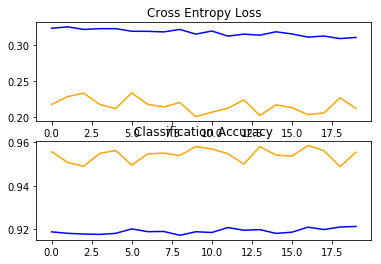

In [37]:
summarize_diagnostics(history20)

In [ ]:
accuracy2 = model2.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
print("Accuracy: ",accuracy2[1])

In [ ]:
!cat /kaggle/input/cs4487cp/test_data/test.py

In [ ]:
df = pd.DataFrame({'Category':test_res})
df['Index'] = df.index
df = df[['Index','Category']]

In [ ]:
df.to_csv('./test_res4.csv',index=False)

In [ ]:
df

In [ ]:
import pickle
pickle.dump(test_res, open('/kaggle/output/test_res','wb'))
test_res

In [ ]:
train_set_norm
test_data_norm

In [ ]:
for i in [pp[3]]:
    for j in training_set:
        if (i == j).all():
            print('WTF?')
    for j in test_data:
        if (i == j).all():
            print('WTF?')

In [ ]:
res = {}

In [ ]:
for i in [15]:
    for j in range(1):
        print('try: '+ str(j))
        print('epoch: '+str(i))
        model = Sequential([
            Conv2D(64, kernel_size=3, activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
            MaxPooling2D((2,2),padding='same'),
            Conv2D(128, kernel_size=3, activation='relu'),
            MaxPooling2D((2,2),padding='same'),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(
            x=training_set_norm,
            y=training_label_one_hot_encode,
            epochs=i,
            batch_size=batch_size,
            verbose=0,
        )
        accuracy = model.evaluate(x=test_data_norm,y=test_label_one_hot_encoded,batch_size=32)
        res[(j,i)] = accuracy[1]
        print("Accuracy: ",accuracy[1])
    

In [ ]:
for i in [5,10,15,20]:
    print('epoch: '+str(i))
    for j in range(3):
        print('try: '+ str(j))
        print('acc: '+ str(res[(j,i)]))

In [ ]:
!pip install efficientnet

In [ ]:
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
conv_base = Net(weights="imagenet", include_top=False, input_shape=input_shape)

In [33]:
import tensorflow as tf

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)
    return out


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



FileNotFoundError: [Errno 2] No such file or directory: 'preprocess_batch_1.p'

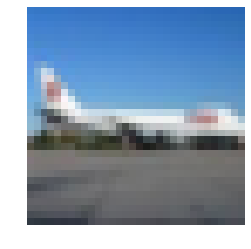